### Land mine classifier

Author: Taha Parsayan
Date: 2025 Jan 07

Make a vertual environment

python -m venv packages

Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass

.\packages\Scripts\Activate.ps1

python.exe -m pip install --upgrade pip
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/

In [70]:
# Importing Libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import shutil
import glob
import Land_mine_data_management_functions as dmf
from PIL import Image
from torch.utils.data import DataLoader
from going_modular import data_setup, engine, model_builder, predictions
import random
from pathlib import Path
from torchinfo import summary
import torch.multiprocessing as mp
from helper_functions import plot_loss_curves

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)


Using device: cuda


### Inspect the existing data

In [85]:
current_path = os.getcwd()
folder_path = 'DatainBrief_dataset_1'
folder_path = os.path.join(current_path, folder_path)

def walk_through_directory(path):
    for root, dirs, files in os.walk(path):
        print(f"Root folder: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print("-" * 40)

data_path = os.path.join(current_path, 'data')
walk_through_directory(data_path)

Root folder: e:\Python-codes\Pytorch\data
Subdirectories: ['FashionMNIST', 'pizza_steak_sushi', 'test', 'train']
Files: ['pizza_steak_sushi.zip']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\FashionMNIST
Subdirectories: ['raw']
Files: []
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\FashionMNIST\raw
Subdirectories: []
Files: ['t10k-images-idx3-ubyte', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte', 'train-labels-idx1-ubyte.gz']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\pizza_steak_sushi
Subdirectories: ['test', 'train']
Files: ['04-pizza-dad.jpeg']
----------------------------------------
Root folder: e:\Python-codes\Pytorch\data\pizza_steak_sushi\test
Subdirectories: ['pizza', 'steak', 'sushi']
Files: []
----------------------------------------
Root fol

### Prepare the data

There are 5 folders containing images of landmines. 
We take 4 of them for training and 1 for testing.

In [86]:

# Names of the landmine types
landmine_types = [
    "Zone 1 Mine 1cm depth",
    "Zone 2 Mine 1cm depth",
    "Zone 3 Mine 1cm depth",
    "Zone 4 Surface Mine 0cm depth",
    "Zone 5 Sruface Mine 0cm depth",
    "Zone 6 free zone",
    "Zone 7 Mine 5cm depth",
    "Zone 8 Mine 5cm depth",
    "Zone 9 Mine 10 cm depth"
]

# Names of image acquisition dates
train_date_folders = [
    "13_02_2020",
    "17_02_2020",
    "20_02_2020",
    "24_02_2020"
]

test_date_folders = [
    "03_03_2020"
]

# Define the path for the 'data' folder
all_data_path = os.path.join(current_path, 'data', 'land_mine')
train_data_path = os.path.join(current_path, 'data','land_mine', 'train')
test_data_path = os.path.join(current_path, 'data','land_mine', 'test')

dmf.create_landmine_folders(train_data_path, landmine_types)
dmf.copy_images_to_landmine_folders(folder_path, train_data_path, landmine_types, train_date_folders)

dmf.create_landmine_folders(test_data_path, landmine_types)
dmf.copy_images_to_landmine_folders(folder_path, test_data_path, landmine_types, test_date_folders)


### See the data
Show one random image from the data

Number of training images: 441
Number of testing images: 123
Random image path: e:\Python-codes\Pytorch\data\land_mine\train\Zone 7 Mine 5cm depth\24_02_2020_12.jpg
Image class: Zone 7 Mine 5cm depth
Image height: 480
Image width: 720
Image mode: RGB
Image format: JPEG


(-0.5, 719.5, 479.5, -0.5)

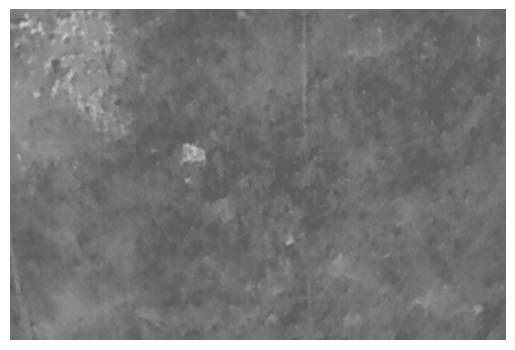

In [87]:
random.seed(42)

all_data_path = Path(all_data_path)
train_data_path = Path(train_data_path)
test_data_path = Path(test_data_path)

train_image_path_list = list(train_data_path.glob("*/*.jpg"))
test_image_path_list = list(test_data_path.glob("*/*.jpg"))

print(f"Number of training images: {len(train_image_path_list)}")
print(f"Number of testing images: {len(test_image_path_list)}")

random_image_path = random.choice(train_image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image mode: {img.mode}")
print(f"Image format: {img.format}")

plt.imshow(img)
plt.axis('off')

### Classification model
ViT classification model
Through transfer learning, we freeze the rest of the data and keep the head layer learnable.

In [88]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
in_features = pretrained_vit.heads.head.in_features
#print(in_features) -> 768

# Transfer learning
# Freez all layers
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Modify other layers and make them learnable
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# # Modify the first convolution layer to accept 1-channel (grayscale) input
# pretrained_vit.conv_proj = nn.Conv2d(
#     in_channels=1,  # Grayscale image (1 channel)
#     out_channels=768,  # Output channels
#     kernel_size=16,  # Same kernel size
#     stride=16  # Same stride
# ).to(device)

# Modify the head layer
dropout_rate = 0.5  # You can adjust the dropout rate as needed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Sequential(
    nn.Dropout(p=dropout_rate),          # Add dropout layer
    nn.Linear(in_features=768, out_features=9)  # Final linear layer
).to(device)

# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 9]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### Dataloader
Prepare the data for training and testing

In [89]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_data_path,
                                                                                                     test_dir=test_data_path,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size = 8)
print(class_names)
print(f"Number of classes: {len(class_names)}")

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
['Zone 1 Mine 1cm depth', 'Zone 2 Mine 1cm depth', 'Zone 3 Mine 1cm depth', 'Zone 4 Surface Mine 0cm depth', 'Zone 5 Sruface Mine 0cm depth', 'Zone 6 free zone', 'Zone 7 Mine 5cm depth', 'Zone 8 Mine 5cm depth', 'Zone 9 Mine 10 cm depth']
Number of classes: 9


### Train the model

In [90]:
# Check the device
print(f"Working on device: {device}")

# Create optimizer and loss function
optimizer = optimizer =torch.optim.Adam(params = pretrained_vit.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Working on device: cuda


 10%|█         | 1/10 [00:54<08:06, 54.02s/it]

Epoch: 1 | train_loss: 2.7824 | train_acc: 0.2455 | test_loss: 2.5695 | test_acc: 0.2292


 20%|██        | 2/10 [01:34<06:08, 46.12s/it]

Epoch: 2 | train_loss: 2.2311 | train_acc: 0.4062 | test_loss: 2.0517 | test_acc: 0.3880


 30%|███       | 3/10 [02:16<05:08, 44.02s/it]

Epoch: 3 | train_loss: 1.9959 | train_acc: 0.4688 | test_loss: 2.2714 | test_acc: 0.4297


 40%|████      | 4/10 [02:57<04:17, 42.94s/it]

Epoch: 4 | train_loss: 1.9432 | train_acc: 0.4844 | test_loss: 2.6488 | test_acc: 0.4141


 50%|█████     | 5/10 [03:38<03:32, 42.41s/it]

Epoch: 5 | train_loss: 1.5272 | train_acc: 0.5670 | test_loss: 2.7223 | test_acc: 0.4219


 60%|██████    | 6/10 [04:20<02:49, 42.27s/it]

Epoch: 6 | train_loss: 1.7589 | train_acc: 0.5692 | test_loss: 2.6388 | test_acc: 0.3594


 70%|███████   | 7/10 [05:02<02:06, 42.13s/it]

Epoch: 7 | train_loss: 1.6429 | train_acc: 0.5737 | test_loss: 2.5131 | test_acc: 0.4453


 80%|████████  | 8/10 [05:44<01:23, 41.99s/it]

Epoch: 8 | train_loss: 1.6714 | train_acc: 0.5871 | test_loss: 2.3643 | test_acc: 0.4245


 90%|█████████ | 9/10 [06:26<00:41, 41.94s/it]

Epoch: 9 | train_loss: 1.6349 | train_acc: 0.6049 | test_loss: 3.0385 | test_acc: 0.4219


100%|██████████| 10/10 [07:07<00:00, 42.79s/it]

Epoch: 10 | train_loss: 1.8428 | train_acc: 0.5692 | test_loss: 2.6614 | test_acc: 0.3906


### Plot model performance

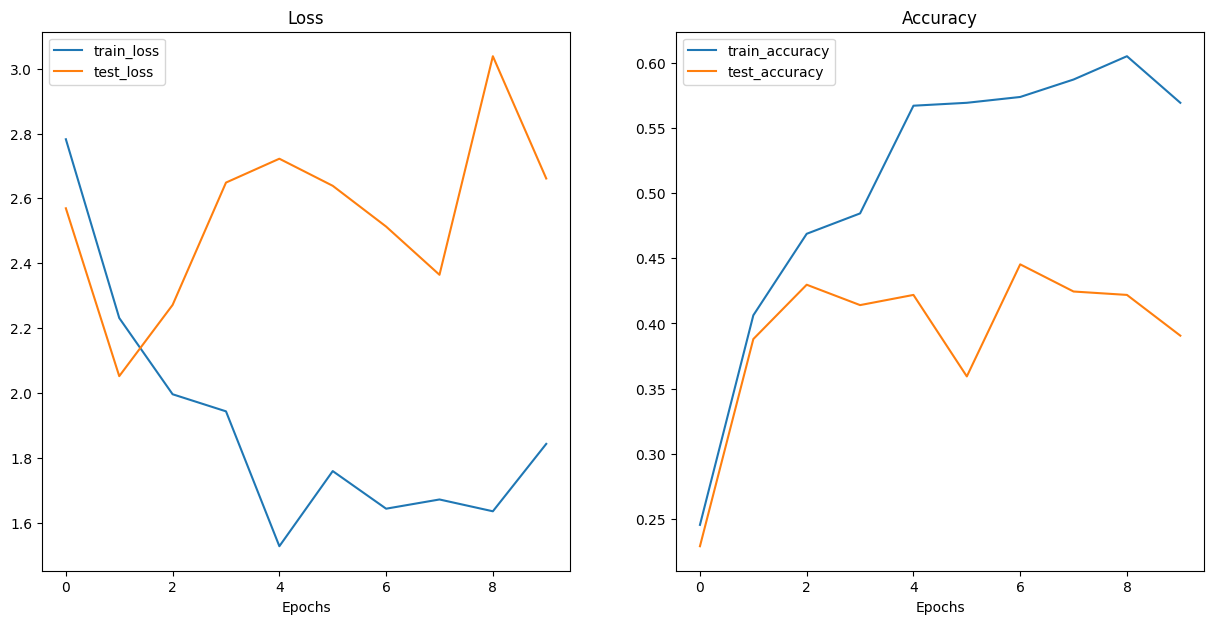

In [91]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)